In [ ]:
# SKforecast boi

### Introduction
A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

When creating a forecaster model, historical data are used to get a mathematical representation capable of predicting future values. This idea is based on a very important assumption: the future behavior of a phenomenon can be explained from its past behavior. However, this rarely happens in reality, or at least not in its entirety. For more on this, see the following definition:
$$ Forecast = pattern + unexplained\;variance $$

The first term of the equation refers to everything that has a repetitive character over time (trend, seasonality, cyclical factors...). The second term represents everything that influences the response variable but is not captured (explained) by the past of the time series.

The greater the importance of the first term relative to the second, the greater the probability of success when attempting to create autoregressive forecasting models. As the second term gains weight, it becomes necessary to incorporate additional variables (if any) into the model to help explain the observed behavior.

A good study of the modeled phenomenon and the ability to recognize to what extent its behavior can be explained by its past can save a lot of unnecessary effort.

This document shows an example of how to identify situations where the autoregressive forecasting process cannot achieve useful results. As an example, an attempt to predict the daily closing price of Bitcoin using machine learning methods is made.

In [ ]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Bitcoin colors
# ==============================================================================
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# Modelling and Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [5]:
# Data download
# ==============================================================================

# Scraper is initialized, symbol, start and end of download are included
scraper = CmcScraper('BTC', '28-04-2013', '01-01-2022')

# Transform collected data into a dataframe
data = scraper.get_dataframe()
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
3170,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3169,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3168,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3167,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3166,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2021-12-28,50679.859377,50679.859377,47414.209925,47588.854777,3.343038e+10,9.000762e+11
3,2021-12-29,47623.870463,48119.740950,46201.494371,46444.710491,3.004923e+10,8.784788e+11
2,2021-12-30,46490.606049,47879.965500,46060.313166,47178.125843,2.668649e+10,8.923863e+11
1,2021-12-31,47169.372859,48472.527490,45819.954553,46306.446123,3.697417e+10,8.759394e+11


In [6]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [7]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


## Bitcoin halving as an exogenous variable


Halving is a programmed event and is part of the design and operation of some cryptocurrencies. The miners validate the transaction blocks of the network, in this case, Bitcoin, and each time they succeed, they receive an amount of that digital currency. This amount varies from time to time.

Every time 210,000 blocks are added, the reward in the Bitcoin blockchain change occurs. This event, called halving, occurs approximately every 4 years and reduces the coins miners receive as a reward by half.

In the history of Bitcoin, there have been 3 halvings. When Bitcoin mining started, miners received 50 BTC for successfully mining a block. In 2012, it reduced this reward to 25 BTC; in 2016, it dropped to 12.5 BTC, and in 2020 to 6.25 BTC, after the third halving. Each halving has affected the price, although it has not been in the short term after it.

It is intended to use the days remaining until the next halving and its mining rewards as exogenous variables to predict the price of Bitcoin. The next halving is estimated to occur approximately in 2024, although its exact date is unknown. The remaining blocks as of 2022-01-14 from the Coinmarketcap website, 121,400, and the average number of Bitcoin network blocks mined per day, 144 (average block time ≈ 10 minutes) are used to determine it.

Note: when incorporating predicted data as an exogenous variable, their error is introduced in the forecasting model since they are predictions.

In [8]:
# Dict with Bitcoin halvings info
# ==============================================================================
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [9]:
# Next halving calculation
# The remaining blocks according to the coinmarketcap.com website for 
# the next halving as of 2022-01-14 are taken as a starting point
# ==============================================================================
remaining_blocks = 121400
blocks_per_day = 144

days = remaining_blocks / blocks_per_day

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=days)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'The next halving will occur on approximately: {next_halving}')

The next halving will occur on approximately: 2024-05-06


In [10]:
# Include rewards and countdown to next halving in dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Start and end date of each halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Fill column 'reward' with mining rewards
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Fill column 'countdown_halving' with remaining days
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [11]:
data.head()

,open,close,high,low,reward,countdown_halving
date,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,25.0,1167.0
2013-04-29,134.444000,144.539993,147.488007,134.000000,25.0,1166.0
2013-04-30,144.000000,139.000000,146.929993,134.050003,25.0,1165.0
2013-05-01,139.000000,116.989998,139.889999,107.720001,25.0,1164.0
2013-05-02,116.379997,105.209999,125.599998,92.281898,25.0,1163.0


In [14]:
# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              ) 

fig = go.Figure(data=[candlestick])

fig.update_layout(
    # width       = 900,
    # height      = 450,
    title       = dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Second halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Third halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Fourth halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

Text(0.5, 0, 'Price (USD)')

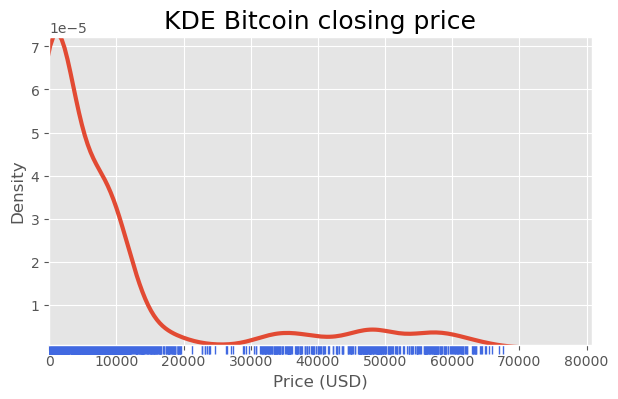

In [15]:
# KDE distribution of Bitcoin closing price
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin closing price', fontsize=18)
p.set_xlabel('Price (USD)')

The study data shows a majority distribution of prices below 20,000 (USD). This stage corresponds to the period between 2013 and September 2020. Since 2021, the price has been in the range of 35,000 - 67,500 (USD).

Trying to model a time series with a highly asymmetric distribution and distinct orders of magnitude over time can cause complications. One strategy is model changes (deltas) rather than direct values to minimize these problems. It could be further simplified, indicating only whether the price increases or decreases from the previous day.

Note: when a distribution is asymmetric, modeling deltas instead of price may result in a more symmetric distribution.

In [17]:
# Create deltas column (% change)
# ==============================================================================
# data['change_pct'] = 100*(data['close'] - data['open']) / data['open']
# # With Pandas pct_change() method
# data['change_pct'] = data.pct_change(axis='columns').iloc[:, 1]*100
# data.head(2)

In [21]:
# Locate corresponding data for each year
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Calculate % change between the open and close price of the year
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(12)

,open,close,low,high,year_change
2013,135.300003,754.010010,65.526001,1156.140015,457.287504
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526
2016,430.721008,963.742981,354.914001,979.396973,123.751097
2017,963.658020,14156.400391,755.755981,20089.000000,1369.027404
2018,14112.200195,3742.700335,3191.303562,17712.400391,-73.478974
2019,3746.713387,7193.598978,3391.023752,13796.489081,91.997579
2020,7194.891971,29001.719822,4106.980750,29244.876688,303.087634
2021,28994.008916,46306.446123,28722.755271,68789.625939,59.710395
2022,46311.744663,47686.811509,46288.486095,47827.310995,2.969154


In [22]:
# Create a list of dicts with the % change annotations for the plot
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.05
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Bitcoin/USD yearly chart</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)

fig.show()

In [23]:
# Locate corresponding data for each month
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for month in range(12):
        
        start_date = pd.to_datetime(f'{year}-{month+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(month+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [24]:
# Boxplot chart for annual seasonality
# ==============================================================================
# df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='month', ax=ax)
# df_plot.groupby('month')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per month')
# fig.suptitle('');

df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 monthly boxplot
fig1 = px.box(df_plot.sort_values('month'), x='month', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each month
df_median = pd.DataFrame(df_plot.groupby('month')['close'].median()).reset_index()
fig2 = px.line(df_median, x='month', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Price per month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='month', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [25]:
# Boxplot chart for monthly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['day'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='day', ax=ax)
# data.groupby('day')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the month')
# fig.suptitle('');

data['day'] = pd.Series(data.index).dt.day.values

# fig 1 dayly boxplot
fig1 = px.box(data.sort_values('day'), x='day', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each day
df_median = pd.DataFrame(data.groupby('day')['close'].median()).reset_index()
fig2 = px.line(df_median, x='day', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Price per day of the month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='day', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [26]:
# Boxplot chart for weekly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['weekday'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='weekday', ax=ax)
# data.groupby('weekday')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the week');

data['weekday'] = data.index.day_of_week + 1

# fig 1 weekly boxplot
fig1 = px.box(data.sort_values('weekday'), x='weekday', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each weekday
df_median = pd.DataFrame(data.groupby('weekday')['close'].median()).reset_index()
fig2 = px.line(df_median, x='weekday', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Price per day of the week</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='weekday', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

Usually, time series with an autoregressive pattern produce a repetitive shape (trend, seasonality, cyclical factors). Regarding Bitcoin, a certain annual seasonality appears at the end and beginning of the year, with larger variations in price. No seasonality appears in the monthly and weekly intervals, with very similar distributions.

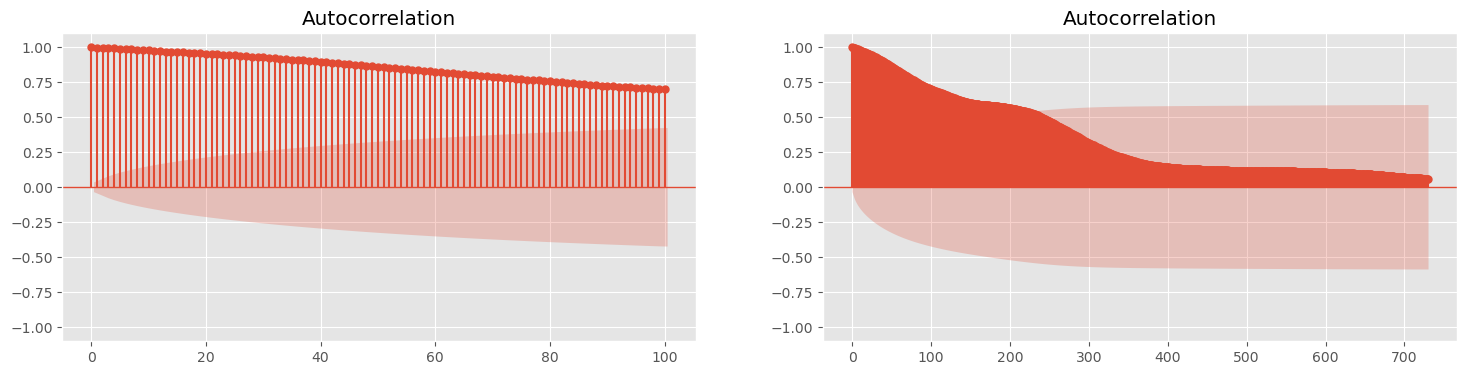

In [27]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

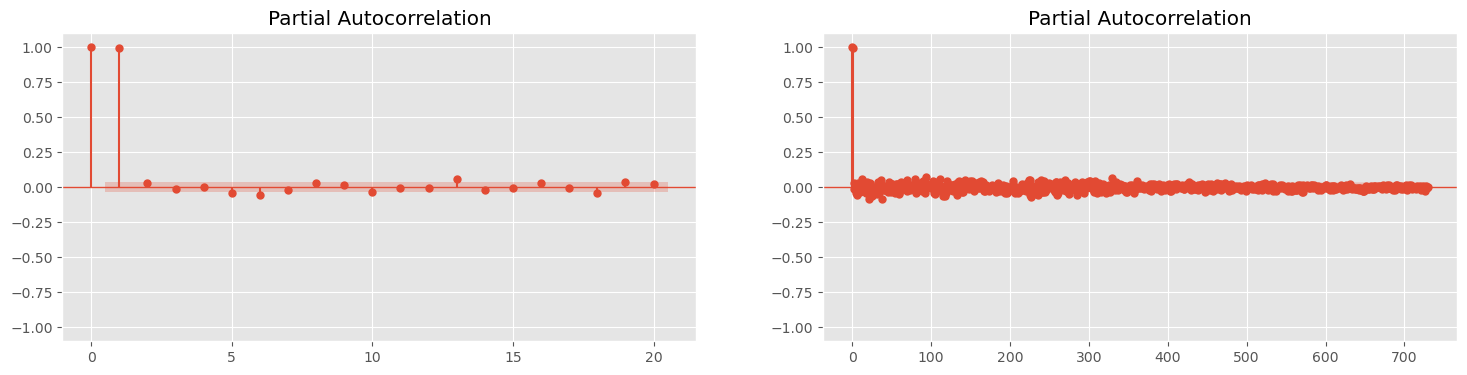

In [28]:
# Partial autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

The autocorrelation plots show that lag 1 is the only one correlated with lag 0. The following lags do not exceed the significance threshold.

## Baseline - Random walk simulation


When generating a predictive model, it is convenient to identify a base model, or baseline, on which to compare each of the proposed iterations or models. In the case of finance, according to random walk theory, market prices behave randomly and not as a function of their time series. Thus, the best estimate of the value  $𝑡𝑛+1$
  is the value  $𝑡𝑛$
  plus an unpredictable change.

Although a broad time series is available, it presents periods with highly differentiated prices, as determined in the graphical exploration. Only data from the last two years are used.

In [29]:
# Selection of train-test dates
# ==============================================================================
start_train = '2020-01-01 00:00:00'
end_train = '2021-06-30 23:59:59'

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")

Complete time series : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00  (n=3171)
Train dates          : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Test dates           : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00  (n=185)


As mentioned above, random walk suggests that the best estimate for the  $𝑡𝑛+1$
  value is the  $𝑡𝑛$
  value plus an unpredictable change. Therefore, the simplest viable model uses the value of  $𝑡𝑛$
  as the prediction for the  $𝑡𝑛+1$
  value. It is set as the baseline model.

In [30]:
# Random walk simulation
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Test error
# ==============================================================================
y_true = df_rw.loc[end_train:, 'close']
y_pred = df_rw.loc[end_train:, 'pred_close']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].head(4))

Test error: 1267.7978352283603


,close,pred_close
date,,
2021-07-01,33572.117653,35040.837249
2021-07-02,33897.048590,33572.117653
2021-07-03,34668.548402,33897.048590
2021-07-04,35287.779766,34668.548402


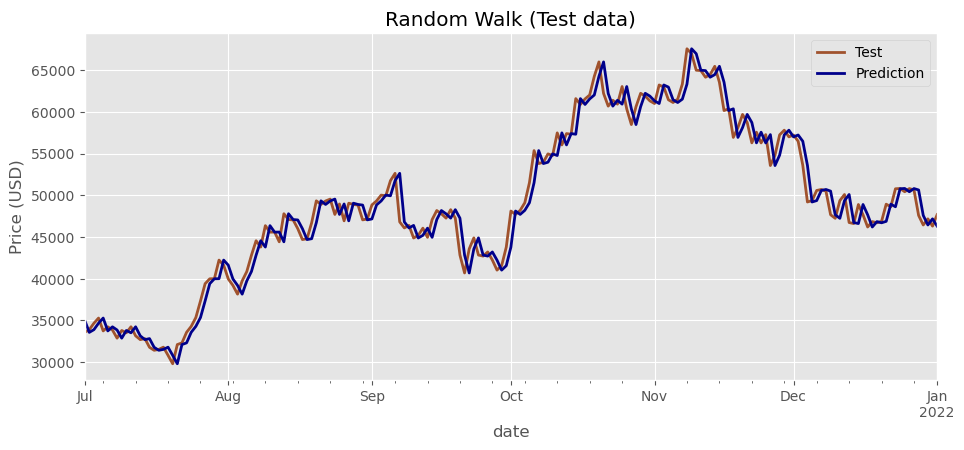

In [31]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test',
                                    c='sienna')
df_rw.loc[end_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Prediction',
                                    c='darkblue')
ax.set_title('Random Walk (Test data)')
ax.set_ylabel('Price (USD)')
ax.legend()

In [32]:
# DataFrame models' test error
# ==============================================================================
df_errors = pd.DataFrame({'model': 'Base - Random Walk', 'lags': 1, 
                          'test_error': metric, 'exog_variables': False},
                         index=[0])
df_errors

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1267.797835,False


## Recursive autoregressive forecaster


An Autoregressive Forecaster (ForecasterAutoreg) with a LightGBM regressor, an implementation of the Gradient Boosting algorithm developed by Microsoft that usually achieves excellent results, is used to model the Bitcoin price.

Previous sections show an absence of autocorrelation beyond the first lag. One way to verify this is to train several models with an increasing amount of lags and check if the error doesn't reduce. This approach can be done by backtesting, using steps = 1 (predict only the next value in the series,  𝑡𝑛+1
 ) it reproduces the random walk model methodology.

Note: It is not rigorously necessary to perform any data preprocessing when working with models based on decision trees (StandardScaler, MinMaxScaler...). Example of forecasting with Scikit-learn pipelines.

In [33]:
# Forecasters backtest with different lags
# ==============================================================================
lags = [1, 7, 30]
metrics = []
predictions_list = []

for lag in lags:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # Backtest test data, 1 step
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data.loc[start_train:, 'close'],
                              initial_train_size = len(data.loc[start_train:end_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 1,
                              refit              = True,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                          )
    
    metrics.append(metric)
    predictions_list.append(predictions)

/opt/anaconda3/lib/python3.8/site-packages/skforecast/model_selection/model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 185 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/185 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/skforecast/model_selection/model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 185 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/185 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/skforecast/model_selection/model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 185 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/185 [00:00<?, ?it/s]

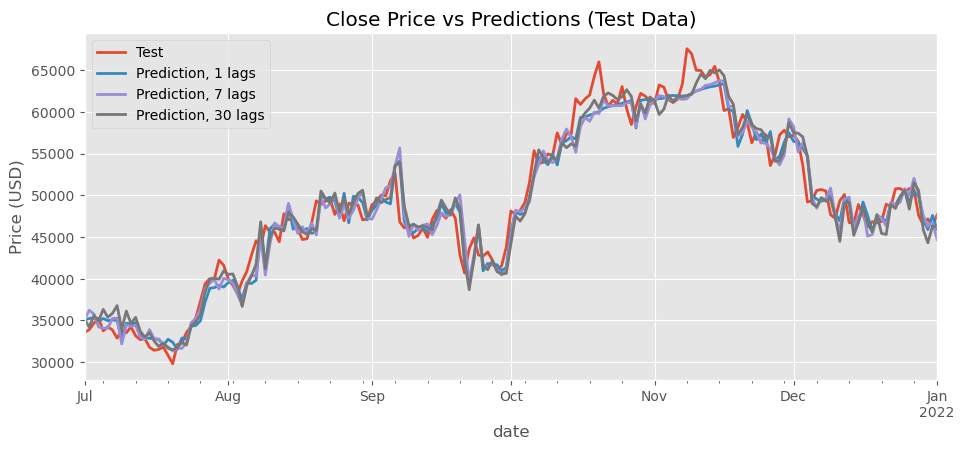

In [34]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot test predictions for different lags
for predictions, lag in zip(predictions_list, lags):
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    predictions.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend()

In [35]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': lags, 
                              'test_error': metrics, 'exog_variables': False})
                ]).reset_index(drop=True)

df_errors.sort_values(by='test_error')

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1267.797835,False
1,LGBMRegressor,1,1529.633756,False
2,LGBMRegressor,7,1582.363518,False
3,LGBMRegressor,30,1601.381059,False


The test errors (which reflect how well each model generalizes) show that none of the models improves the baseline despite incorporating more information from the past (number of lags). Because of the results, other alternatives are tested, such as incorporating exogenous variables into the series.

## Forecasting with exogenous variables


In the previous example, only lags of the predicted variable itself have been used as predictors. In some scenarios, it is possible to have information about other variables, whose future value is known, and which can serve as additional predictors in the model. Typical examples are:

* Holidays (local, national...)

* Month of the year

* Day of the week

* Time of day

For this case, it is used the variables resulting from the section about Bitcoin halving and, after studying seasonality, the month of the year.

Note: The reward and month variables, although encoded as numbers, are categorical, so it is convenient to change the type with which they are stored. Since these variables do not have many levels, the One Hot Encoding transformation is used to incorporate them into the model.

In [36]:

# Change of the categorical variables to category type
# ==============================================================================
data['month'] = data.index.month
data['month'] = data['month'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'month'])
data.head(2)

,open,close,high,low,countdown_halving,day,weekday,reward_6.25,reward_12.5,reward_25.0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,1167.0,28,7,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.444000,144.539993,147.488007,134.000000,1166.0,29,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [37]:
# All exogenous variables are selected, including those obtained  
# during one hot encoding.
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'month'))]
exog.extend(['countdown_halving'])
print(exog)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'countdown_halving']


In [38]:
# Forecaster backtest with exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Backtest test data, 1 step
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[start_train:, 'close'],
                          exog               = data.loc[start_train:, exog],
                          initial_train_size = len(data.loc[start_train:end_train, 'close']),
                          fixed_train_size   = True,
                          steps              = 1,
                          refit              = True,
                          metric             = 'mean_absolute_error',
                          verbose            = False
                      )

/opt/anaconda3/lib/python3.8/site-packages/skforecast/model_selection/model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 185 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/185 [00:00<?, ?it/s]

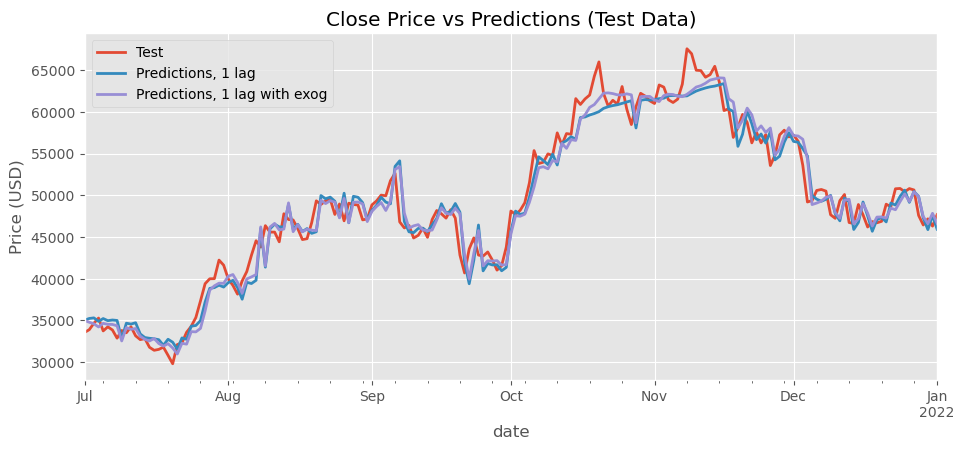

In [39]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot predictions 1 lag without exogenous variables
predictions_no_exog = predictions_list[0].rename(columns={'pred': f'Predictions, 1 lag'})
predictions_no_exog.plot(ax=ax, linewidth=2)

# Plot predictions 1 lag with exogenous variables
predictions_exog = predictions.rename(columns={'pred': f'Predictions, 1 lag with exog'})
predictions_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend()

In [40]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': 1, 
                              'test_error': metric, 'exog_variables': True},
                             index=[4])
                ]).reset_index(drop=True)

df_errors.sort_values(by='test_error')

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1267.797835,False
4,LGBMRegressor,1,1473.148609,True
1,LGBMRegressor,1,1529.633756,False
2,LGBMRegressor,7,1582.363518,False
3,LGBMRegressor,30,1601.381059,False
